In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from core.data_gen import DataGen
from core.loss_minimization import LowerBound
from core.utils import *

import seaborn as sns 
sns.set()

from tqdm import tqdm
import tensorflow as tf
import pickle

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
figdir='./figs'

This notebook contains code for autism experiment presented in **section 6 (Experiment)** of the paper. 

**Data Generation**
Use `DataGen` class in `core.data_gen` to generate both randomized and confounded data, here is an example code snippet.

```python
from core.data_gen import DataGen
dgen = DataGen(config=config_data) # make the generator class
dgen.SMART(sample_size) # generates randomized data
dgen.Confounded(sample_size) # generates confounded data
```

Information about the data generation is passed by the `config` dictionary. This dictionary containts:
* `sigma`: amount of noise in data generation (look at Lu et al. (2016, Appendix B) for more detail). For all  experiments this value is set to 1.
* `theta`: varibale that effects the effect size(look at Lu et al. (2016, Appendix B) for more detail).
* `Gamma`: amount of confounding in data generation process (this value is represented by $\Gamma^\star$ in plots).

**Compute lower bound**
To run our method and compute the naive lower bound use the class `LowerBound` in `core.loss_minimization`, the class requires a `config` dictionary, `train_data` and `eval_data`.  Here is a code snippet how to use this class.

```python
# build the class
lower_bound = LowerBound(config, train_data, eval_data, scope='awesome')
bounds, loss = lower_bound.run() # ouput bounds and loss value
```

The output of the function `LowerBound.run()` is 
1. `bounds` : a tuple `(float: our method, float: naive)` that is the lowerbound computed by our method and naive bound
2. `loss` :a numpy array `float: [num_iteration, num_actions]` that is the loss value for optimization of each action.

`train_data` and `eval_data` are output of `DataGen` class.

the `config` dictioanry contains the following informations:

* `Gamma`: amount of counfoding.
* `epoch`: number of epochs for training
* `batch_size`: size of training batch, if `None` uses the whole data in each batch.
* `lr`: learning rate for optimizer
* `action_set` : a list of all possible actions at step of confounding.
* `evaluation_policy` is the evaluaton policy tuple `(A_1, A_2)`
* `slow_responder`: if only look at slow responders. 

In this example `A1 = {0, 1}` which corresponds to `{-1,1}` and `A2 = {0, 1, 2}` corresponding to `{-1, 0, 1}` (see the appendix). In all experimetns presented here we are interested in the value of the adaptive policy `BLI+AAC` which corresponds to to `evaluation_policy = (1, 0)`

# Case I

Case I is a case where the adaptive policy `BLI+AAC` has lower value than the non-adaptive policy `AAC`; however with confounding $\Gamma^\star=2.0$ it looks otherwise. In this example we showed that using our method, we cannot gurantee that `BLI+AAC` is a better policy. Data generation configuration of Case I is:

```python
config_data = {'sigma': 1, 'theta': 0.95, 'Gamma': 2.0}
```
Here on the left you see randomized data, and on the confounded data.

Effect Size = 0.312


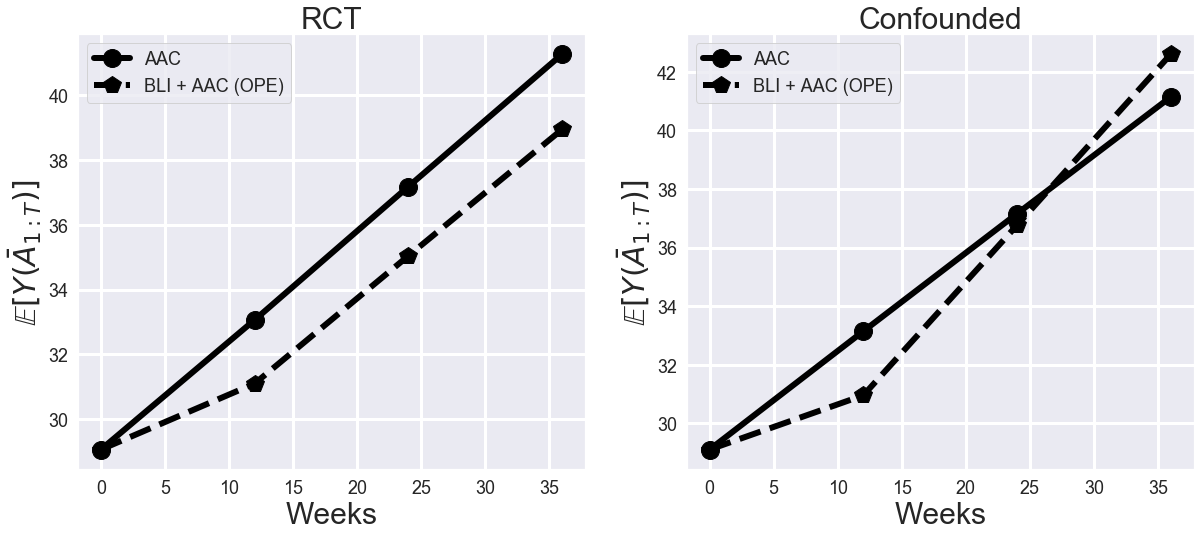

In [10]:
config_data = {'sigma': 1, 'theta': 0.95, 'Gamma': 2.0}
Generator = DataGen(config=config_data)

sample_size = 50000
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
data = Generator.Gen(sample_size, RCT=True)
_, true_pi_adaptive = compute_observational_policy_value(data)
plot_autism(data, title='RCT');
print("Effect Size = {:.3f}".format(compute_effect_size(data)))

plt.subplot(1,2,2)
train_data = Generator.Gen(sample_size, RCT=False)
eval_data = Generator.Gen(sample_size, RCT=False)
plot_autism(train_data, title='Confounded');

Here we calculate lowerbound on our method and naive for $\Gamma=2.0$ and $\Gamma=3.0$.

In [ ]:
tf.reset_default_graph()
config = {'action_set': [0, 1, 2], 'Gamma': 2.0, 
          'epoch': 200, 'batch_size': None, 'lr': 1e-3,
          'evaluation_policy': (1, 0), 'slow_responder': True}
lower_bound = LowerBound(config, train_data, eval_data, 'gamma2')
bounds_gamma_2, loss_gamma_2 = lower_bound.run(use_tqdm=True)

In [ ]:
config = {'action_set': [0, 1, 2], 'Gamma': 3.0, 
          'epoch': 200, 'batch_size': None, 'lr': 1e-3,
          'evaluation_policy': (1, 0), 'slow_responder': True}
lower_bound_3 = LowerBound(config, train_data, eval_data, 'CaseI_gamma3')
bounds_gamma_3, loss_gamma_3 = lower_bound_3.run(use_tqdm=True)

In [793]:
# with open('results/caseI.pkl', 'wb') as f:
#     pickle.dump({'Gamma2': (bounds_gamma_2, loss_gamma_2),
#                  'Gamma3': (bounds_gamma_3, loss_gamma_3),
#                 'OPE': true_pi_adaptive}, f)

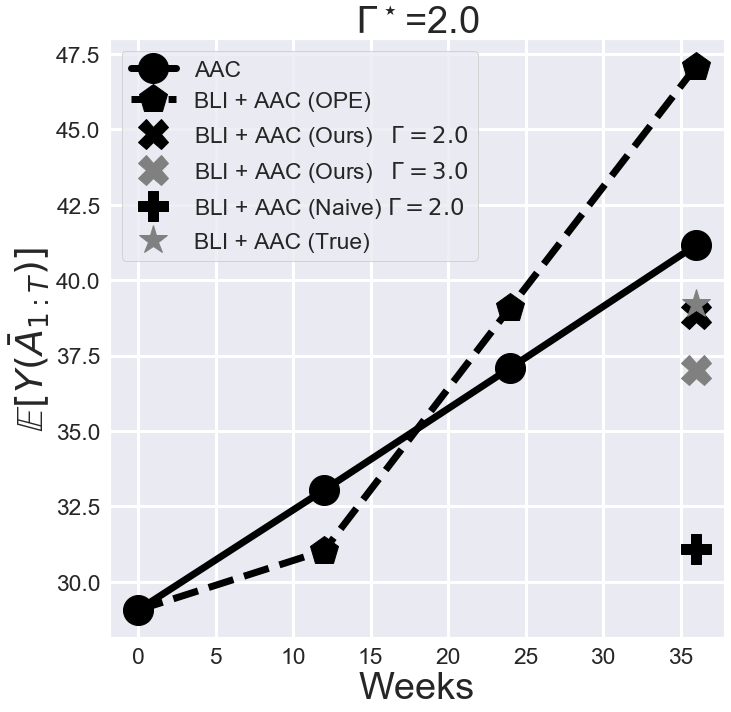

In [44]:
plt.figure(figsize=(11, 11))
evaluations = {'BLI + AAC (Ours)   $\Gamma=2.0$': 
               (36, bounds_gamma_2[0], 'black', 'X'),
              'BLI + AAC (Ours)   $\Gamma=3.0$': 
               (36, bounds_gamma_3[0], 'gray', 'X'),
              'BLI + AAC (Naive) $\Gamma=2.0$':
              (36, bounds_gamma_2[1], 'black', 'P'),
              'BLI + AAC (True)': 
               (36, true_pi_adaptive[-1], 'gray', '*')}
plot_autism(train_data, title=r'$\Gamma^\star$=2.0', evaluations=evaluations,
           markersize=30, linewidth=7, fontsize=38);
plt.savefig("{}/autims-case-I.pdf".format(figdir))

# Case II

Case II is a case where the adaptive policy `BLI+AAC` has better value than the non-adaptive policy `AAC` (larger effect size); with confounding $\Gamma^\star=2.0$ it looks even better. In this example we showed that using our method, we can gurantee that `BLI+AAC` is a better policy up to misspecification of the counfouding $\Gamma=4.2$. Data generation configuration of Case II is

```python
config_data = {'sigma': 1, 'theta': 2.3, 'Gamma': 2.0}
```
Here on the left you see randomized data, and on the confounded data.

Effect Size = 0.80


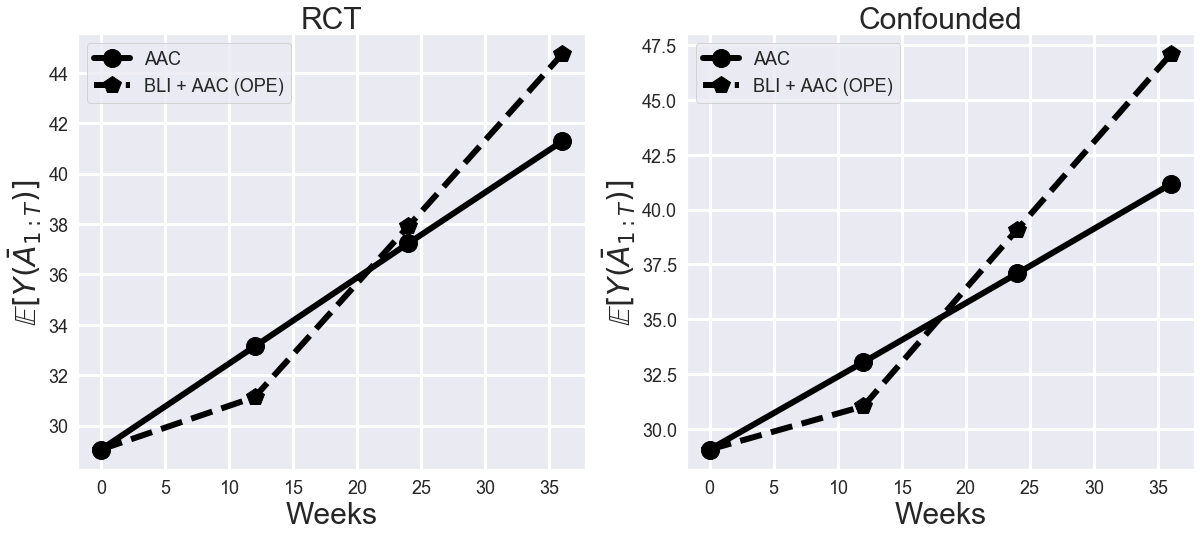

In [27]:
config_data = {'sigma': 1, 'theta': 2.3, 'Gamma': 2.0}
Generator = DataGen(config=config_data)

sample_size = 50000
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
data = Generator.Gen(sample_size, RCT=True)
_, true_pi_adaptive = compute_observational_policy_value(data)
plot_autism(data, title='RCT');
print("Effect Size = {:.2f}".format(compute_effect_size(data)))

plt.subplot(1,2,2)
train_data = Generator.Gen(sample_size, RCT=False)
eval_data = Generator.Gen(sample_size, RCT=False)
plot_autism(train_data, title='Confounded');

let's calculate our and naive bound for $\Gamma=2.0$ and $\Gamma=4.2$.

In [ ]:
tf.reset_default_graph()
config = {'action_set': [0, 1, 2], 'Gamma': 2.0, 
          'epoch': 200, 'batch_size': None, 'lr': 1e-3,
          'evaluation_policy': (1, 0), 'slow_responder': True}
lower_bound = LowerBound(config, train_data, eval_data, 'test')
bounds_gamma_2, loss_gamma_2 = lower_bound.run(use_tqdm=True)

In [ ]:
tf.reset_default_graph()
config = {'action_set': [0, 1, 2], 'Gamma': 4.2, 
          'epoch': 300, 'batch_size': None, 'lr': 1e-3,
          'evaluation_policy': (1, 0), 'slow_responder': True}
lower_bound = LowerBound(config, train_data, eval_data, 'test')
bounds_gamma_42, loss_gamma_42 = lower_bound.run(use_tqdm=True)

In [35]:
# with open('results/caseII.pkl', 'wb') as f:
#     pickle.dump({'Gamma2': (bounds_gamma_2, loss_gamma_2),
#                  'Gamma42': (bounds_gamma_42, loss_gamma_42),
#                 'OPE': true_pi_adaptive}, f)

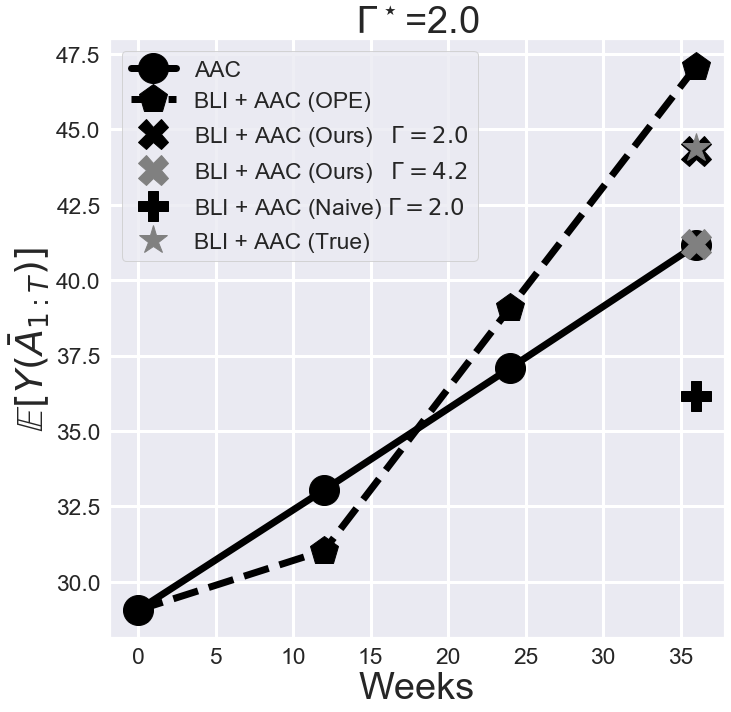

In [42]:
plt.figure(figsize=(11, 11))
evaluations = {'BLI + AAC (Ours)   $\Gamma=2.0$': 
               (36, bounds_gamma_2[0], 'black', 'X'),
              'BLI + AAC (Ours)   $\Gamma=4.2$': 
               (36, bounds_gamma_42[0], 'gray', 'X'),
              'BLI + AAC (Naive) $\Gamma=2.0$':
              (36, bounds_gamma_2[1], 'black', 'P'),
              'BLI + AAC (True)': 
               (36, true_pi_adaptive[-1], 'gray', '*')}

plot_autism(train_data, title=r'$\Gamma^\star$=2.0', evaluations=evaluations,
           markersize=30, linewidth=7, fontsize=38);

plt.savefig("{}/autims-case-II.pdf".format(figdir))

# Design Sensitivity

This section, generates unconfounded data ($\Gamma^\star=1.0$), and evaluates our and naive bound with different $\Gamma$. The goal is to see where our lowerbound estimate of the policy `BLI+AAC` will cross the true value of the policy `AAC`. 

In [66]:
config_data = {'sigma': 1.0, 'theta': 2.6, 'Gamma': 1.0}
Generator = DataGen(config=config_data)

sample_size = 20000
train_data = Generator.Gen(sample_size, RCT=True)
eval_data = Generator.Gen(sample_size, RCT=True)
true_pi_aac, true_pi_adaptive = compute_observational_policy_value(train_data)
print("Effect Size = {:.2f}".format(compute_effect_size(train_data)))

Effect Size = 0.90


In [5]:
Gammas = np.arange(1.0, 4.5, 0.5)

naive_bound = np.zeros(Gammas.shape[0])
our_bound = np.zeros(Gammas.shape[0])

tf.reset_default_graph()
config = {'action_set': [0, 1, 2], 'Gamma': None, 
          'epoch': 300, 'batch_size': None, 'lr': 1e-3,
          'evaluation_policy': (1, 0), 'slow_responder': True}
for idx, gamma in tqdm(enumerate(Gammas)):
    config['Gamma'] = gamma
    lower_bound = LowerBound(config, train_data, eval_data, 'desing_%d'%(idx))
    bounds, _ = lower_bound.run(use_tqdm=False)
    our_bound[idx], naive_bound[idx] = bounds

7it [00:49,  7.04s/it]


In [6]:
# with open('results/sensitivity.pkl', 'wb') as f:
#     pickle.dump((our_bound, naive_bound), f)

In [62]:
with open('results/sensitivity.pkl', 'rb') as f:
    our_bound, naive_bound = pickle.load(f)
Gammas = np.arange(1.0, 4.5, 0.5)

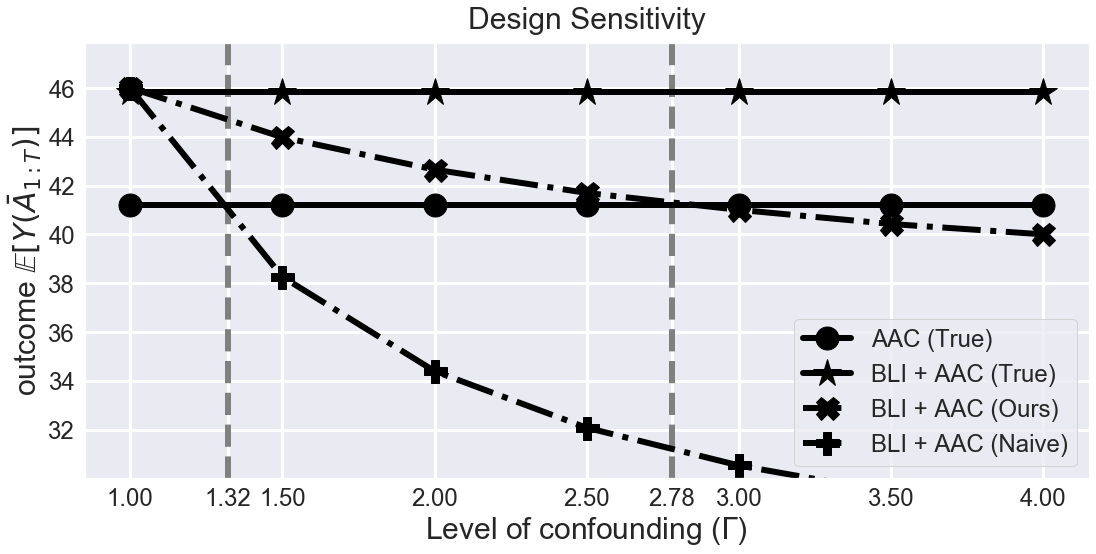

In [81]:
plt.figure(figsize=(18, 8))

plot_autism_design_sensitivity({'our': our_bound, 'naive': naive_bound,
                               'aac': true_pi_aac[-1], 'adaptive': true_pi_adaptive[-1],
                               'Gammas': Gammas, 'cross': (1.32, 2.78)},
                              title='Design Sensitivity')
plt.savefig("{}/autims-sensitivity.pdf".format(figdir))